# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.   

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from keras.preprocessing.image import ImageDataGenerator

In [77]:
labels = pd.read_csv('labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=42)

Found 7591 validated image filenames.


In [78]:
labels

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


Размер выборки составляет 7591 фото, что является достаточным работы с датасетом, однако выборку можно увеличить с помощью аугментаций для получения лучшего результата.

In [79]:
features, target = next(gen_flow)

In [80]:
features.shape

(32, 224, 224, 3)

In [81]:
target.shape

(32,)

Выведем несколько фото из датасета:

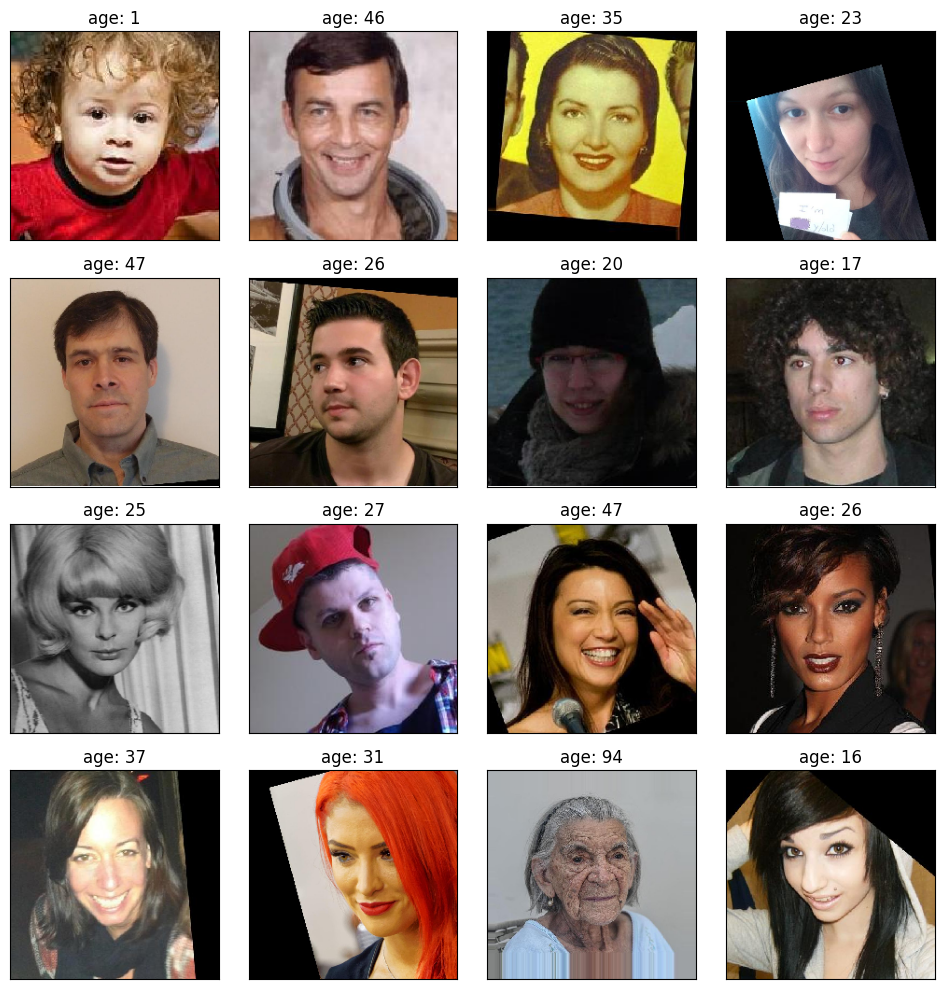

In [82]:
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(f'age: {target[i]}')    
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

В датасете можно увидеть фото, уже прошедшие обработку - присутствуют повернутые, со случайным кропом, черно-белые.

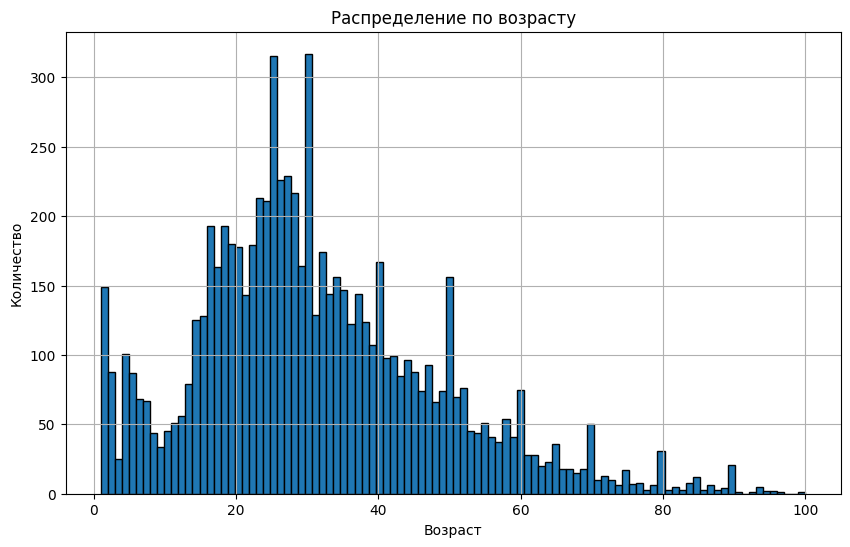

In [83]:
plt.figure(figsize=(10,6))
plt.hist(labels['real_age'], bins=100, edgecolor='black')
plt.title('Распределение по возрасту')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.grid(True);

Сильных выбросов и некорректных значений нет.

По итогам анализа можно сделать следующие выводы:

* Размер выборки составляет 7591 фото, что является достаточным работы с датасетом;
* Возраст людей на фото составляет от года до 100 лет, наибольшее число с возрастом от 18 до 40 лет. Также можно увидеть пики на значениях, кратных 10 - 30, 40 , 50 и тд., можно предположить, что на таких фото возраст определялся примерно и округлялся.
* К изображениям уже применены аугментации - определенены лица и вырезаны из фото, фото повернуты так, чтобы лицо располагалось вертикально.
* Из аугментаций к датасету можно применить также horizontal_flip - это позволит увеличить выборку, при этом не силь искажая изображения.

## Обучение модели

In [84]:
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

In [85]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.20, horizontal_flip=True)

train_datagen_flow = train_datagen.flow_from_dataframe(dataframe = labels, 
                                                       directory = ('final_files/'), 
                                                       x_col='file_name',
                                                       y_col='real_age',     
                                                       target_size=(224, 224),
                                                       batch_size=32,
                                                       shuffle=True,
                                                       class_mode='raw',
                                                       subset='training',
                                                       seed=42)

Found 6073 validated image filenames.


In [86]:
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.20)

val_datagen_flow = val_datagen.flow_from_dataframe(dataframe = labels, 
                                                     directory = ('final_files/'),
                                                     x_col='file_name',
                                                     y_col='real_age',
                                                     target_size=(224, 224),
                                                     batch_size=32,
                                                     shuffle=False,
                                                     class_mode='raw',
                                                     subset='validation',
                                                     seed=42)

Found 1518 validated image filenames.


In [87]:
from tensorflow.keras.applications import ResNet50

model = ResNet50(weights='imagenet')

In [117]:
backbone = ResNet50(input_shape=(224, 224, 3),
                    weights='resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)

model = Sequential()
model.add(backbone)
model.add(GlobalAveragePooling2D())
model.add(Dense(1, activation='relu')) 

optimizer = Adam(lr=1e-4)
model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

In [90]:
history = model.fit(train_datagen_flow,
          validation_data=val_datagen_flow,
          batch_size=32, epochs=30,
          steps_per_epoch=6073 // 32,
          validation_steps=1518 // 32,
          verbose=2)

Epoch 1/30



189/189 - 1250s - loss: 220.8286 - mae: 11.3504 - val_loss: 711.8469 - val_mae: 21.6436 - 1250s/epoch - 7s/step
Epoch 2/30
189/189 - 1122s - loss: 143.5475 - mae: 9.1735 - val_loss: 355.4502 - val_mae: 14.0118 - 1122s/epoch - 6s/step
Epoch 3/30
189/189 - 1115s - loss: 125.3919 - mae: 8.5176 - val_loss: 289.0358 - val_mae: 12.9836 - 1115s/epoch - 6s/step
Epoch 4/30
189/189 - 1112s - loss: 107.3308 - mae: 7.9138 - val_loss: 422.0886 - val_mae: 15.5036 - 1112s/epoch - 6s/step
Epoch 5/30
189/189 - 1109s - loss: 97.0483 - mae: 7.4933 - val_loss: 148.4696 - val_mae: 9.1398 - 1109s/epoch - 6s/step
Epoch 6/30
189/189 - 1109s - loss: 84.1111 - mae: 7.0134 - val_loss: 178.1279 - val_mae: 9.9428 - 1109s/epoch - 6s/step
Epoch 7/30
189/189 - 1118s - loss: 71.9773 - mae: 6.4674 - val_loss: 113.7741 - val_mae: 8.1804 - 1118s/epoch - 6s/step
Epoch 8/30
189/189 - 1116s - loss: 63.8828 - mae: 6.1331 - val_loss: 102.1682 - val_mae: 7.5010 - 1116s/epoch - 6s/step
Epoch 9/30
189/189 - 1110s - loss: 61.9262

In [91]:
# model.save("model_new.h5")
loaded_model = tf.keras.saving.load_model("model_new.h5")

C:\Users\user\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [92]:
from sklearn.metrics import mean_absolute_error

# Получение фактических меток из объекта DataFrameIterator
actual_labels = val_datagen_flow.labels

# Предсказания модели
predictions = loaded_model.predict(val_datagen_flow)

# Вычисление среднего MAE
mae_score = mean_absolute_error(actual_labels, predictions)
print('Average MAE:', mae_score)

48/48 [==============================] - 96s 2s/step
Average MAE: 6.623252021406479


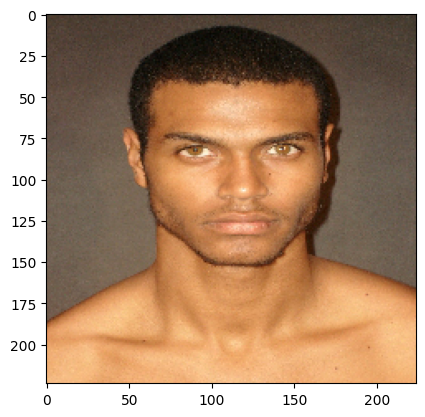

1/1 [==============================] - 0s 165ms/step
Predicted Age: 24.88 years


In [116]:
import random
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet import preprocess_input

# Путь к папке с тестовыми изображениями
test_folder = 'test/'

# Получение списка файлов в папке "test"
test_images = os.listdir(test_folder)

# Выбор случайной картинки из папки "test"
random_image_filename = random.choice(test_images)
random_image_path = os.path.join(test_folder, random_image_filename)

# # Загрузка и предобработка изображения
img = image.load_img(random_image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0
# img_array = preprocess_input(img_array.reshape(1, 224, 224, 3))

# # Вывод изображения
plt.imshow(img)
plt.show()

# # Предсказание с использованием модели
prediction = loaded_model.predict(img_array)
predicted_age = prediction[0][0]

print(f'Predicted Age: {predicted_age:.2f} years')

## Анализ обученной модели

С помощью сети ResNet50, предобученной на датасете ImageNet, было получено значение МАЕ 5.7, что входит в заданное значение до 8, то есть при определении возраста модель ошибается в среднем на 5.7 лет.

Это делает модель непригодной для анализа возраста при продаже алкоголя, однако может быть полезной для того, чтобы предлагать товары, которые могут заинтересовать покупателей определенной возрастной группы - здесь такая погрешность допустима.